<a href="https://colab.research.google.com/github/maminu-coder/Deep_Learning_using_tensorFlow_keras/blob/main/06_LR_Shedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Learning Rate Schedulers</h1>

When training a model from scratch, we generally start with a higher learning rate, but as the learning progresses, reducing the learning rate can help improve the rate of convergence and sometimes even results in increased accuracy (lower loss). In TensorFlow, we can add Learning Rate Schedulers using the [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) module.

In this notebook, we will learn about three different learning rate schedulers in TensorFlow using the [Rock, Paper, Scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) data from TensorFlow datasets [tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds). Specifically, we'll take a look at the following learning rate schedulers:

* Piecewise Constant Decay
* Inverse Time Decay
* Exponential Decay


<img src='https://learnopencv.com/wp-content/uploads/2023/02/c4-04-learning-rate-feature-image_02.png' width=1000 align='center'><br/>




## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Rock-Paper-Scissors Dataset](#3-Rock-Paper-Scissors-Dataset)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 Training Function](#5-Training-Function)
* [6 Training using SGD (Gradient Desent) with Momentum](#6-Training-using-SGD-%28Gradient-Desent%29-with-Momentum)
* [7 Training with Learning Rate Schedulers](#7-Training-with-Learning-Rate-Schedulers)
    * [7.1 PiecewiseConstantDecay Scheduler](#7.1-PiecewiseConstantDecay-Scheduler)
    * [7.2 InverseTimeDecay Scheduler](#7.2-InverseTimeDecay-Scheduler)
    * [7.3 ExponentialDecay Scheduler](#7.3-ExponentialDecay-Scheduler)
* [8 Plot Loss Curves](#8-Plot-Loss-Curves)
* [9 Conclusion](#9-Conclusion)

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Flatten, Dense)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False

## 1 System Configuration

In [ ]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int   = 32
    EPOCHS:        int   = 51
    LEARNING_RATE: float = 0.0001
    ROOT_LOG_DIR         = "./scheduler_logs"
    ROOT_CHECKPOINT_DIR  = "./scheduler_saved_models"

@dataclass(frozen=True)
class DatasetConfig:
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    CHANNELS:     int = 3
    NUM_CLASSES:  int = 3

## 3 Rock-Paper-Scissors Dataset

In [ ]:
# Define a dictionary mapping labels names to label IDs.
label_names = {
    'Rock'     : 0,
    'Paper'    : 1,
    'Scissors' : 2,
}

### 3.1 Load the Dataset

Load the dataset using the TensorFlow Dataset module: [tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds)

In [ ]:
def get_data():

    # Download and split the data.
    rps_train = tfds.load(name="rock_paper_scissors", split=tfds.Split.TRAIN, batch_size=-1)
    rps_test  = tfds.load(name="rock_paper_scissors", split=tfds.Split.TEST, batch_size=-1)

    rps_train = tfds.as_numpy(rps_train)
    rps_test  = tfds.as_numpy(rps_test)

    X_train, y_train = rps_train["image"], rps_train["label"]
    X_test,  y_test  = rps_test["image"],  rps_test["label"]

    return (X_train, y_train), (X_test, y_test)

### 3.2 Data Preprocessing Pipeline

In [ ]:
def preprocess_dataset(train_set, valid_set, resize_to=None, num_classes=3, seed=3):

    (X_train, y_train) = train_set
    (X_valid, y_valid) = valid_set

    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)

    # Resize images if requested.
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to)

        X_train = tf.image.resize(X_train, resize_to)
        X_valid = tf.image.resize(X_valid, resize_to)

    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]

    image_shape = X_train[0].shape

    print("There are {} training examples ".format(n_train))
    print("There are {} validation examples".format(n_valid))
    print("Image data shape is {}".format(image_shape))

    # Confirm the number of classes present in the dataset matches the specified number of classes.
    assert num_classes == len(np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."

    print('There are {} classes'.format(num_classes))

    # One-hot encode labels if necessary.
    if len(y_train.shape) != 2:
        y_train = to_categorical(y_train, num_classes)
        y_valid = to_categorical(y_valid, num_classes)

    print(f"\n\nX_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_valid: {X_valid.shape}, y_validation: {y_valid.shape}")

    X_train = tf.cast(X_train, dtype=tf.float32)
    X_valid = tf.cast(X_valid, dtype=tf.float32)

    # Normalize the pixel values to the range [0., 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return (X_train, y_train), (X_valid, y_valid)

### 3.3 Data Visualization

In [ ]:
def visualize_samples(X, y):
    plt.figure(figsize=(18, 8))

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap=plt.cm.binary)
        plt.xlabel(list(label_names.keys())[y[i]])

    plt.suptitle("Dataset Samples")
    plt.show(block=block_plot)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.I1BTGZ_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.I1BTGZ_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


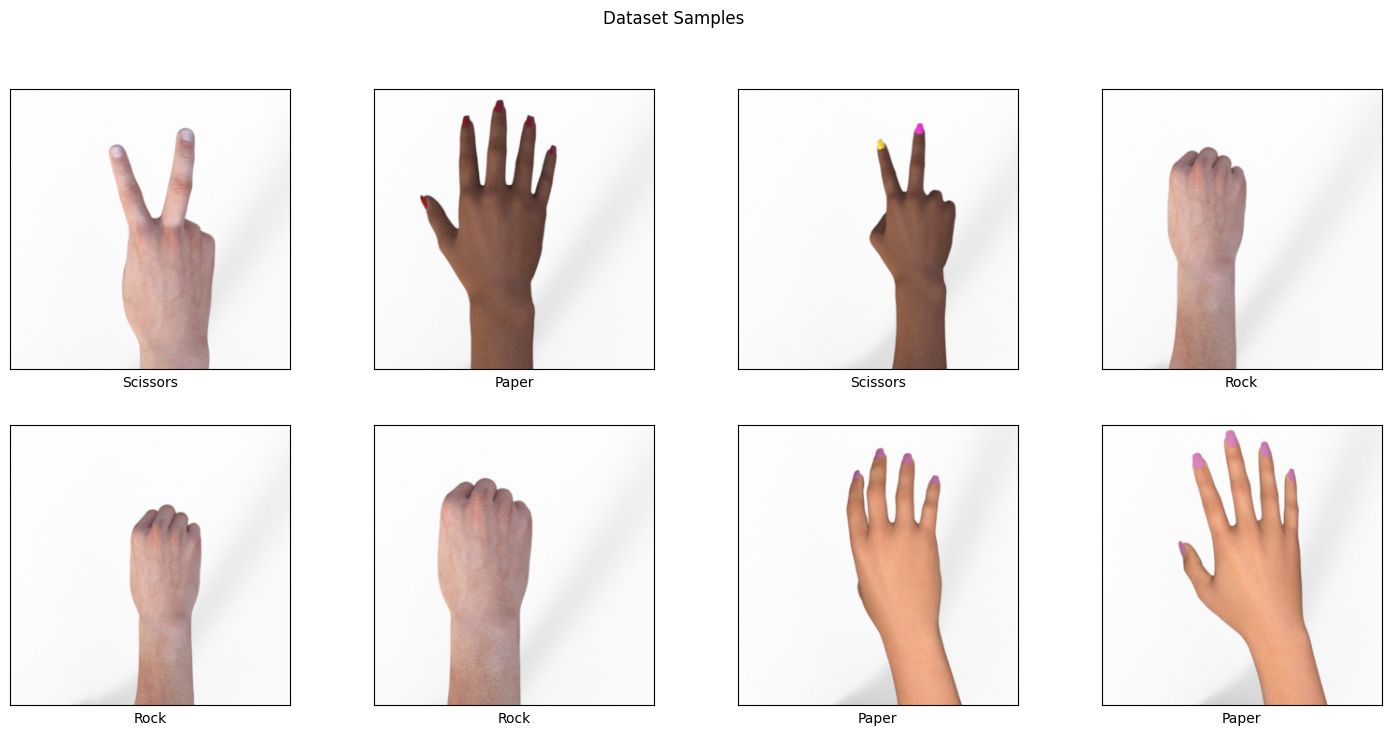

In [ ]:
# Load the dataset.
(X_train_in, y_train_in), (X_valid_in, y_valid_in) = get_data()

visualize_samples(X_valid_in, y_valid_in)

### 3.4 Preprocess the Dataset

In [ ]:
# Preprocess the dataset.
((X_train, y_train),
(X_valid, y_valid)) = preprocess_dataset((X_train_in, y_train_in),
                                        (X_valid_in, y_valid_in),
                                        resize_to=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                        num_classes=DatasetConfig.NUM_CLASSES,
                                        )

There are 2520 training examples 
There are 372 validation examples
Image data shape is (32, 32, 3)
There are 3 classes


X_train: (2520, 32, 32, 3), y_train: (2520, 3)
X_valid: (372, 32, 32, 3), y_validation: (372, 3)


## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)

    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # -------------------------
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84

    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10

    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')

    if print_model_summary:
        model.summary()

    return model

## 5 Training Function

In [ ]:
def train_model(train_set,
                valid_set,
                scheduler,
                version_number,
                epochs=TrainingConfig.EPOCHS,
                print_model_summary=False,
               ):

    os.makedirs(TrainingConfig.ROOT_LOG_DIR, exist_ok=True)
    os.makedirs(TrainingConfig.ROOT_CHECKPOINT_DIR, exist_ok=True)

    folders = os.listdir(TrainingConfig.ROOT_LOG_DIR)

    if len(folders):
        last_version_number = int(sorted(folders)[-1].replace("version_", ""))
        version_number = last_version_number + 1

    log_dir = os.path.join(TrainingConfig.ROOT_LOG_DIR, f"version_{version_number}")
    checkpoint_dir = os.path.join(TrainingConfig.ROOT_CHECKPOINT_DIR, f"version_{version_number}.weights.h5")

    os.makedirs(log_dir, exist_ok=True)
    # os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")

    (X_train, y_train) = train_set
    (X_valid, y_valdi) = valid_set

    # Initialize the LeNet Model.
    model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES,
                         shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS),
                         print_model_summary=print_model_summary,
                        )

    # Compile the model for the requested scheduler.
    if scheduler=="Fixed":

        # Fixed learning rate.
        model.compile(tf.keras.optimizers.SGD(learning_rate=TrainingConfig.LEARNING_RATE, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )

    elif scheduler=="PiecewiseConstantDecay":

        # Define the PiecewiseConstantDecay LR Scheduler.
        # total_steps = epochs * len(X_train) / batch_size;
        # Each boundary is set to be appoximately 3rd of total steps.
        boundaries = [1300, 2600]
        values = [0.001, 0.0001, 0.00001]
        learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )

    elif scheduler=="InverseTimeDecay":

        # Define the InverseTimeDecay LR Scheduler.
        initial_learning_rate = 0.1
        learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                                          decay_steps=1,
                                                                          decay_rate=0.5,
                                                                         )

        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )

    elif scheduler=="ExponentialDecay":

        # Define the ExponentialDecay LR Scheduler.
        initial_learning_rate = 0.001
        learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                          decay_steps=100,
                                                                          decay_rate=0.96,
                                                                          staircase=True,
                                                                         )

        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
    else:

        print("Invalid scheduler: ", scheduler)
        exit()

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=0,
                                                          write_graph=True,
                                                          write_images=False,
                                                          write_steps_per_second=False,
                                                          update_freq="epoch",
                                                          profile_batch=2,
                                                          embeddings_freq=0,
                                                          embeddings_metadata=None,
                                                         )

    # Save best model depending on the validation accuracy.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{checkpoint_dir}.keras",
                                                                   save_weights_only=False,
                                                                   monitor="val_accuracy",
                                                                   mode="max",
                                                                   save_best_only=True,
                                                                  )

    print(f"\nTraining for {epochs} epochs\n")

    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=TrainingConfig.BATCH_SIZE,
                        validation_data=(X_valid, y_valid),
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                       )

    return results, version_number

## 6 Training using SGD (Gradient Desent) with Momentum
Gradient descent update rule:

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n}
         \end{bmatrix}
$$

***Function Syntax:***

```
tf.keras.optimizers.SGD(learning_rate=0.01,
                        momentum=0.0,
                        nesterov=False,
                        name='SGD',
                        **kwargs,
                        )
```

- `learning_rate` – A Tensor, floating point value, or a schedule that is a `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.01.

- `momentum` – float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Defaults to 0, i.e., vanilla gradient descent.

- `nesterov` – boolean. Whether to apply Nesterov momentum. Defaults to `False`.

- `name` – Optional name prefix for the operations created when applying gradients. Defaults to "SGD".

- `**kwargs` – Keyword arguments. Allowed to be one of "clipnorm" or "clipvalue". "clipnorm" (float) clips gradients by norm; "clipvalue" (float) clips gradients by value.

[SGD Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [ ]:
# Set the initial version number.
version_number = 0

# Train with SGD with momentum.
training_results_FIX, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='Fixed',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS,
                                                   print_model_summary=True,
                                                  )

Logging at: ./scheduler_logs/version_0


Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,411 (239.89 KB)

 Trainable params: 61,411 (239.89 KB)

 Non-trainable params: 0 (0.00 B)


Training for 51 epochs

Epoch 1/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3307 - loss: 1.1029

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3306 - loss: 1.1029 - val_accuracy: 0.3333 - val_loss: 1.1045
Epoch 2/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3327 - loss: 1.1006 - val_accuracy: 0.3333 - val_loss: 1.1021
Epoch 3/51
64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3841 - loss: 1.0943

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3819 - loss: 1.0946 - val_accuracy: 0.3522 - val_loss: 1.1011
Epoch 4/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3974 - loss: 1.0944

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4014 - loss: 1.0942 - val_accuracy: 0.3575 - val_loss: 1.1005
Epoch 5/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4570 - loss: 1.0902 - val_accuracy: 0.3522 - val_loss: 1.1000
Epoch 6/51
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5011 - loss: 1.0891

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5013 - loss: 1.0890 - val_accuracy: 0.3817 - val_loss: 1.0993
Epoch 7/51
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5342 - loss: 1.0853

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5345 - loss: 1.0853 - val_accuracy: 0.4167 - val_loss: 1.0989
Epoch 8/51
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5394 - loss: 1.0828

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5397 - loss: 1.0827 - val_accuracy: 0.4409 - val_loss: 1.0984
Epoch 9/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5507 - loss: 1.0796

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5533 - loss: 1.0795 - val_accuracy: 0.4516 - val_loss: 1.0981
Epoch 10/51
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 1.0758

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5827 - loss: 1.0758 - val_accuracy: 0.4624 - val_loss: 1.0978
Epoch 11/51
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6008 - loss: 1.0730

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6007 - loss: 1.0729 - val_accuracy: 0.4758 - val_loss: 1.0971
Epoch 12/51
70/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5894 - loss: 1.0690

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5893 - loss: 1.0689 - val_accuracy: 0.4919 - val_loss: 1.0963
Epoch 13/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5901 - loss: 1.0665

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5902 - loss: 1.0665 - val_accuracy: 0.4973 - val_loss: 1.0953
Epoch 14/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5877 - loss: 1.0622 - val_accuracy: 0.4892 - val_loss: 1.0941
Epoch 15/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5798 - loss: 1.0587 - val_accuracy: 0.4946 - val_loss: 1.0931
Epoch 16/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6121 - loss: 1.0510 - val_accuracy: 0.4892 - val_loss: 1.0922
Epoch 17/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5890 - loss: 1.0477 - val_accuracy: 0.4892 - val_loss: 1.0911
Epoch 18/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6141 - loss: 1.0398 - val_accuracy: 0.4866 - val_loss: 1.0890
Epoch 19/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6017 - loss: 1.0366 - val_accuracy: 0.4919 - val_loss: 1.0879
Epoch 20/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5945 - loss: 1.0293 - val_accuracy: 0.4812 - val_loss: 1.0

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5972 - loss: 1.0007 - val_accuracy: 0.5054 - val_loss: 1.0793
Epoch 24/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6219 - loss: 0.9888 - val_accuracy: 0.4892 - val_loss: 1.0804
Epoch 25/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6181 - loss: 0.9783 - val_accuracy: 0.4624 - val_loss: 1.0735
Epoch 26/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 0.9616

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6224 - loss: 0.9610 - val_accuracy: 0.5215 - val_loss: 1.0699
Epoch 27/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6235 - loss: 0.9536 - val_accuracy: 0.5134 - val_loss: 1.0648
Epoch 28/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6371 - loss: 0.9292 - val_accuracy: 0.5108 - val_loss: 1.0561
Epoch 29/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6604 - loss: 0.9048

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6566 - loss: 0.9051 - val_accuracy: 0.5403 - val_loss: 1.0546
Epoch 30/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6754 - loss: 0.8933 - val_accuracy: 0.5054 - val_loss: 1.0460
Epoch 31/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6526 - loss: 0.8704 - val_accuracy: 0.5134 - val_loss: 1.0382
Epoch 32/51
73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6850 - loss: 0.8323

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6844 - loss: 0.8330 - val_accuracy: 0.5511 - val_loss: 1.0159
Epoch 33/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6855 - loss: 0.8242 - val_accuracy: 0.5269 - val_loss: 1.0015
Epoch 34/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7276 - loss: 0.7983 - val_accuracy: 0.5161 - val_loss: 1.0057
Epoch 35/51
66/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6963 - loss: 0.7682

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6998 - loss: 0.7676 - val_accuracy: 0.5941 - val_loss: 0.9922
Epoch 36/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7519 - loss: 0.7415 - val_accuracy: 0.5376 - val_loss: 0.9527
Epoch 37/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7728 - loss: 0.6982 - val_accuracy: 0.5161 - val_loss: 0.9309
Epoch 38/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7498 - loss: 0.6862 - val_accuracy: 0.5349 - val_loss: 0.8924
Epoch 39/51
67/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.6425

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8012 - loss: 0.6429 - val_accuracy: 0.6505 - val_loss: 0.8758
Epoch 40/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8011 - loss: 0.6193 - val_accuracy: 0.5349 - val_loss: 0.8830
Epoch 41/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8097 - loss: 0.5943 - val_accuracy: 0.6505 - val_loss: 0.8305
Epoch 42/51
64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.5718

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8363 - loss: 0.5697 - val_accuracy: 0.6586 - val_loss: 0.8103
Epoch 43/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.5419

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8569 - loss: 0.5418 - val_accuracy: 0.6694 - val_loss: 0.8260
Epoch 44/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8584 - loss: 0.5146 - val_accuracy: 0.6156 - val_loss: 0.7931
Epoch 45/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8652 - loss: 0.4890 - val_accuracy: 0.6156 - val_loss: 0.7623
Epoch 46/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.4776

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8733 - loss: 0.4750 - val_accuracy: 0.6747 - val_loss: 0.7259
Epoch 47/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8822 - loss: 0.4590 - val_accuracy: 0.6317 - val_loss: 0.7264
Epoch 48/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.4348

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8957 - loss: 0.4336 - val_accuracy: 0.7446 - val_loss: 0.7293
Epoch 49/51
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.4084

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9048 - loss: 0.4084 - val_accuracy: 0.7903 - val_loss: 0.7001
Epoch 50/51
66/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9005 - loss: 0.3848

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9007 - loss: 0.3860 - val_accuracy: 0.8065 - val_loss: 0.6897
Epoch 51/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8960 - loss: 0.3995 - val_accuracy: 0.7554 - val_loss: 0.6561


## 7 Training with Learning Rate Schedulers

### 7.1 PiecewiseConstantDecay Scheduler
The `PiecewiseConstantDecay` returns a 1-arg callable to compute the piecewise constant when passed the current optimizer step.

***Function Syntax:***

```
tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries,
                                                     values,
                                                     name=None)
```

where:
* `boundaries`: A list of Tensors or ints or floats with strictly increasing entries, and with all elements having the same type as the optimizer step.
* `values`: A list of Tensors or floats or ints that specifies the values for the intervals defined by boundaries. It should have one more element than boundaries, and all elements should have the same type.
* `name`: A string. Optional name of the operation. Defaults to 'PiecewiseConstant'.

[PiecewiseConstantDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay)

In [ ]:
# Train with PiecwiseConstantDecay.
training_results_PCD, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='PiecewiseConstantDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS,
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_1

Training for 51 epochs

Epoch 1/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3748 - loss: 1.0987

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3758 - loss: 1.0985 - val_accuracy: 0.3763 - val_loss: 1.0738
Epoch 2/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5947 - loss: 1.0129

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5970 - loss: 1.0058 - val_accuracy: 0.4839 - val_loss: 0.9912
Epoch 3/51
65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6855 - loss: 0.8117

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6876 - loss: 0.8019 - val_accuracy: 0.6317 - val_loss: 0.8826
Epoch 4/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 0.5441

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8138 - loss: 0.5433 - val_accuracy: 0.7446 - val_loss: 0.7264
Epoch 5/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9079 - loss: 0.3133 - val_accuracy: 0.7097 - val_loss: 0.6214
Epoch 6/51
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9344 - loss: 0.2009

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9353 - loss: 0.1996 - val_accuracy: 0.8091 - val_loss: 0.4568
Epoch 7/51
64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.1047

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9848 - loss: 0.1026 - val_accuracy: 0.8468 - val_loss: 0.4581
Epoch 8/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9909 - loss: 0.0627 - val_accuracy: 0.7661 - val_loss: 0.4722
Epoch 9/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9907 - loss: 0.0503 - val_accuracy: 0.7903 - val_loss: 0.4983
Epoch 10/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0465 - val_accuracy: 0.8387 - val_loss: 0.4735
Epoch 11/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.0255 - val_accuracy: 0.8306 - val_loss: 0.4492
Epoch 12/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0173 - val_accuracy: 0.8468 - val_loss: 0.4831
Epoch 13/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9986 - loss: 0.0167 - val_accuracy: 0.8199 - val_loss: 0.5229
Epoch 14/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0122 - val_accuracy: 0.8065 - val_loss: 0.513

### 7.2 InverseTimeDecay Scheduler
This scheduler applies the inverse decay function to an optimizer step, given a provided initial learning rate.

$$
\alpha = \frac{\alpha_0}{1+\gamma n}
$$

where,
$\alpha_0$ = inital learning rate  
$\gamma$ = decay_rate  
$n$ = step / decay_steps

***Function Syntax:***

```
tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                               decay_steps,
                                               decay_rate,
                                               staircase=False,
                                               name=None,
                                               )
```

where:
* `initial_learning_rate`: A scalar `float32` or `float64` Tensor or a Python number. The initial learning rate.
* `decay_steps`: How often to apply decay.
* `decay_rate`: A Python number. The decay rate.
* `staircase`: Whether to apply decay in a discrete staircase, as opposed to continuous, fashion.
* `name`: String. Optional name of the operation. Defaults to 'InverseTimeDecay'.

The learning rate is computed as:

```python
def decayed_learning_rate(step):
  return initial_learning_rate / (1 + decay_rate * step / decay_steps)
```

[InverseTimeDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay)

In [ ]:
# Train with InverseTimeDecay.
training_results_ITD, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='InverseTimeDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS,
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_2

Training for 51 epochs

Epoch 1/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3223 - loss: 1.1275

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3224 - loss: 1.1273 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3232 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3206 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3308 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3344 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 6/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3454 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 7/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3075 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 8/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3292 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Ep

### 7.3 ExponentialDecay Scheduler
This schedule applies an exponential decay function to an optimizer step, given an initial learning rate.

$$
\alpha = \alpha_0*\gamma^n
$$

where,
$\alpha_0$ = inital learning rate  
$\gamma$ = decay_rate  
$n$ = steps / decay_steps

***Function Syntax:***
```
tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                               decay_steps,
                                               decay_rate,
                                               staircase=False,
                                               name=None,
                                               )
```

where:
* `initial_learning_rate`: A scalar `float32` or `float64` Tensor or a Python number. The initial learning rate.
* `decay_steps`: A scalar `int32` or `int64` Tensor or a Python number. Must be positive. See the decay computation above.
* `decay_rate`: A scalar `float32` or `float64` Tensor or a Python number. The decay rate.
* `staircase`: Boolean. If `True` decay the learning rate at discrete intervals
* `name`: String. Optional name of the operation. Defaults to 'ExponentialDecay'.

The learning rate is computed as:

```python
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

[ExponentialDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

In [ ]:
# Train with ExponentialDecay.
training_results_EXP, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='ExponentialDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS,
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_3

Training for 51 epochs

Epoch 1/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4180 - loss: 1.0841

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4187 - loss: 1.0837 - val_accuracy: 0.4489 - val_loss: 1.0721
Epoch 2/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5704 - loss: 0.9748

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5707 - loss: 0.9742 - val_accuracy: 0.4892 - val_loss: 0.9884
Epoch 3/51
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6692 - loss: 0.7863

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6699 - loss: 0.7836 - val_accuracy: 0.5188 - val_loss: 0.9715
Epoch 4/51
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7114 - loss: 0.6791

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7150 - loss: 0.6741 - val_accuracy: 0.5591 - val_loss: 0.7930
Epoch 5/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.4694 - val_accuracy: 0.5242 - val_loss: 1.0339
Epoch 6/51
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.3388

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8944 - loss: 0.3374 - val_accuracy: 0.7124 - val_loss: 0.7485
Epoch 7/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.2052 - val_accuracy: 0.6989 - val_loss: 0.7232
Epoch 8/51
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.1335

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9715 - loss: 0.1331 - val_accuracy: 0.7446 - val_loss: 0.8698
Epoch 9/51
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.1188

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9757 - loss: 0.1179 - val_accuracy: 0.7500 - val_loss: 0.7495
Epoch 10/51
64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0672

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9895 - loss: 0.0681 - val_accuracy: 0.7661 - val_loss: 0.7713
Epoch 11/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9908 - loss: 0.0616 - val_accuracy: 0.7446 - val_loss: 0.8032
Epoch 12/51
64/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0495

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9928 - loss: 0.0486 - val_accuracy: 0.7984 - val_loss: 0.8181
Epoch 13/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9937 - loss: 0.0368 - val_accuracy: 0.7527 - val_loss: 0.9502
Epoch 14/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0277 - val_accuracy: 0.7796 - val_loss: 0.8602
Epoch 15/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9976 - loss: 0.0239 - val_accuracy: 0.7473 - val_loss: 0.8420
Epoch 16/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0179 - val_accuracy: 0.7231 - val_loss: 0.8488
Epoch 17/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0202 - val_accuracy: 0.7419 - val_loss: 1.0635
Epoch 18/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0161 - val_accuracy: 0.7608 - val_loss: 0.8558
Epoch 19/51
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9995 - loss: 0.0135 - val_accuracy: 0.7823 - val_loss: 0.9

## 8 Plot Loss Curves

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(20, 8))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

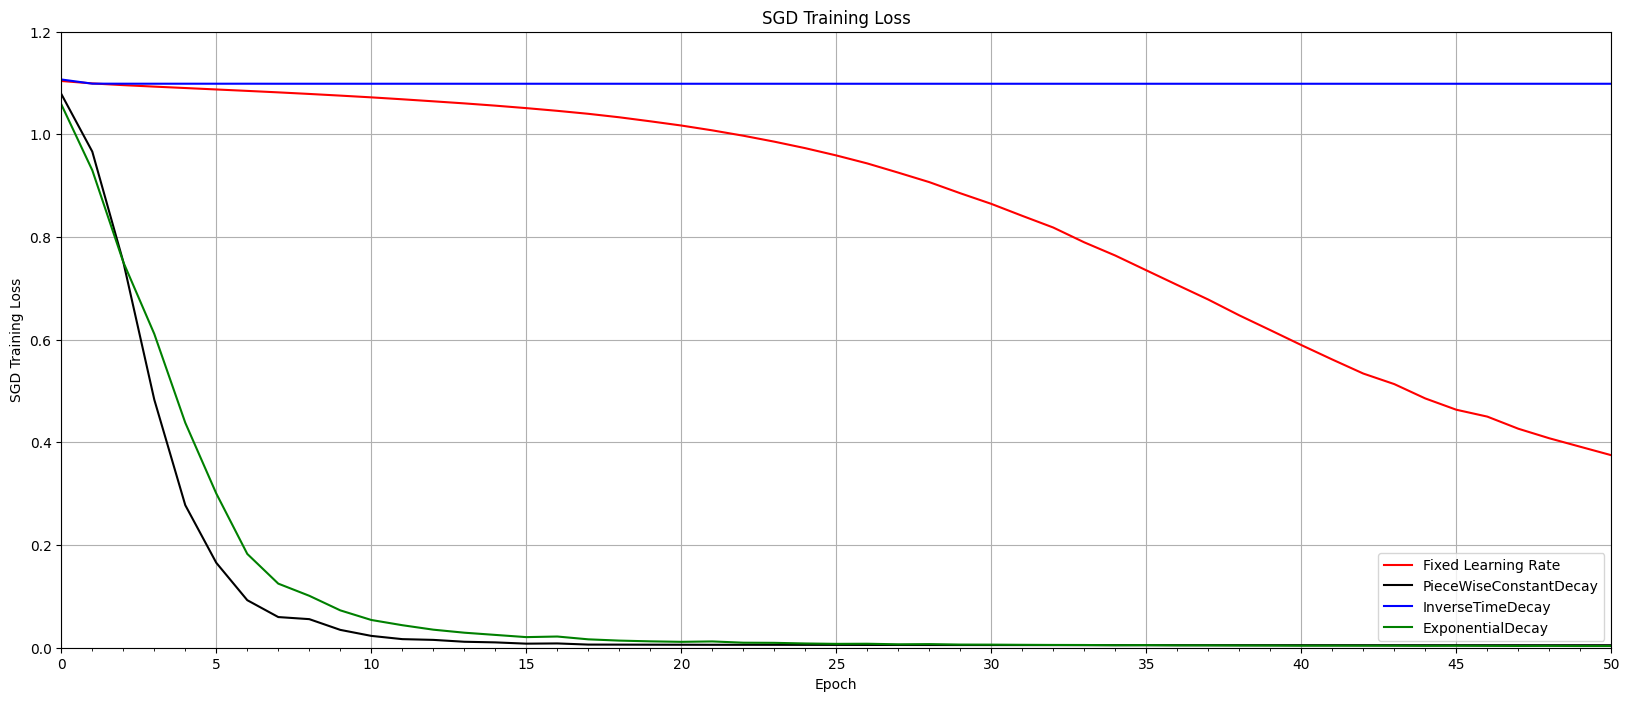

In [ ]:
train_loss_fix = training_results_FIX.history['loss']
train_loss_pcd = training_results_PCD.history['loss']
train_loss_itd = training_results_ITD.history['loss']
train_loss_exp = training_results_EXP.history['loss']

plot_results([ train_loss_fix, train_loss_pcd, train_loss_itd, train_loss_exp ],
            ylabel="SGD Training Loss",
            ylim = [0.0, 1.2],
            metric_name=["Fixed Learning Rate", "PieceWiseConstantDecay", "InverseTimeDecay", "ExponentialDecay"],
            color=['r', 'k', 'b', 'g'])

## 9 Conclusion

In this notebook, we explored the use of three different learning rate schedulers and found that they can dramatically improve the convergence rate of the model. As is often the case in deep learning, experimentation is often required and recommended to confirm which settings work best for your particular problem. Selecting an appropriate optimizer and learning rate scheduler can make a big difference in the amount of time required to train your model and can sometimes lead to higher accuracy as well.